# Sentiment Classification 

## **RNN w/ Bidirectional LSTM**

### Women's Clothing Reviews

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation

nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Read in the data we are working with from file 
df = pd.read_csv("../content/Womens Clothing E-Commerce Reviews.csv")

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)

#### DATA PREPROCESSING

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

#### Word Embeddings

In [ ]:
#Create a series of product reviews and convert the text to a string then lowercase
reviews = df['Review Text'].astype(str).str.lower()

#Creates the features by converting np series to list
features = reviews.tolist()

In [ ]:
#Loop through the features by their index
for index in range(len(features)):

    #Get the charaters/words at each index of the features, check if it is a punctuation mark, if it isn't add it to the list, join that final list
    all_text = ''.join([character for character in features[index] if character not in punctuation])

    #Look at each review and split it base on the characters '\n', '\r'
    features[index] = re.split(r'\n|\r', all_text)

    #Look at each review, loop through the words in that review and add to list, join that list based on spaces
    features[index] = ' '.join([word for word in features[index]])

#Check the features to make sure we get what we want
features      

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

12272 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

63.35570469798658% of 19370 words were covered


#### Machine Learning

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)

<ipython-input-14-f761efe04561>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset_main = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
# open file in write mode
with open('test_dataset_main_RNN.npy', 'wb') as f:
    np.save(f, test_dataset_main[0])
    np.save(f, test_dataset_main[1])

In [ ]:
#Use GPU
with tf.device('/device:GPU:0'):

  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the Bidirectional RNN w/ LSTM layer to the model
    #LSTM will have an output in the 256 dim space 
    #Outputs of forward and backward RNN will be summed
  model.add(Bidirectional(LSTM(256), merge_mode='sum'))

  #Add a layer with a dropout rate of 0.5
  model.add(Dropout(0.50))

  #A a dense layer with dims 3 and softmax activation function
  model.add(Dense(3, activation='softmax'))

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we stat with 5 epochs and a batch size of 256 to match the dims of LSTM, verbose just outputs training info to user
  model.fit(train_dataset[0], train_dataset[1], epochs=5, batch_size=256, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset_main[0], test_dataset_main[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Epoch 1/5
71/71 [==============================] - 23s 203ms/step - loss: 0.2954 - accuracy: 0.9194 - val_loss: 0.2589 - val_accuracy: 0.9342
Epoch 2/5
71/71 [==============================] - 13s 185ms/step - loss: 0.2499 - accuracy: 0.9309 - val_loss: 0.2385 - val_accuracy: 0.9342
Epoch 3/5
71/71 [==============================] - 13s 188ms/step - loss: 0.2287 - accuracy: 0.9311 - val_loss: 0.2145 - val_accuracy: 0.9324
Epoch 4/5
71/71 [==============================] - 13s 190ms/step - loss: 0.2104 - accuracy: 0.9330 - val_loss: 0.2121 - val_accuracy: 0.9319
Epoch 5/5
71/71 [==============================] - 1s 17ms/step - loss: 0.2081 - accuracy: 0.9258
loss : 0.20812411606311798, acc : 0.9257622361183167


In [ ]:
# saving model.
model.save("WomenRNN")

# load model.
#reconstructed_model = keras.models.load_model("my_model")

In [ ]:
with open('test_dataset_main_RNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 3s 24ms/step


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.62      0.06      0.11       161
 (1) Neutral class       0.00      0.00      0.00        12
(2) Positive class       0.93      1.00      0.96      2090

          accuracy                           0.93      2263
         macro avg       0.52      0.35      0.36      2263
      weighted avg       0.90      0.93      0.90      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[  10    0  151]
 [   2    0   10]
 [   4    1 2085]]


<Axes: >

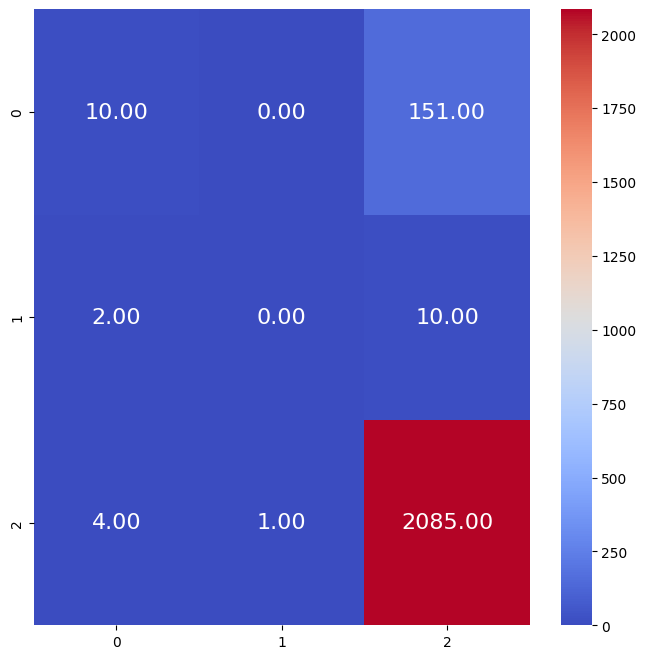

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

### Fipkart Product Reviews

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Read in the reviews
reviewsDF = pd.read_csv('/content/Dataset-SA.csv')

In [ ]:
#Drop NA
def dropNA(df):
  return df.dropna()

#Drop Duplicates
def dropDup(df):
  return df.drop_duplicates()

reviewsDF = dropNA(reviewsDF)
reviewsDF = dropDup(reviewsDF)

In [ ]:
#Drop ID column
def dropID(df):
  df = df.drop(['Unnamed: 0'], axis=1)
  return df

#Convert all reviews to a strings 
def toString(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].astype('str')
  return df

#Remove punctuation from text
def removePunc(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  return df

#Split text into individual tokens
def splitSen(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.split(' '))
  return df

#Remove Whitespace elements from list and set case to lower
def removeSpace(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke.lower() for toke in x if toke.isalpha()])
  return df

#Remove stopwords from text
def removeStop(df, reviewColumn):
  stoplist = set(stopwords.words('english'))
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke for toke in x if toke not in stoplist])
  return df

#Get word stems
def getStems(df, reviewColumn):
  porter = PorterStemmer()
  df[reviewColumn] = df[reviewColumn].map(lambda x: [porter.stem(toke) for toke in x ])
  return df

#Create a vocabulary 
def getVocab(df, reviewColumn):
  reviewsVocab = {}
  for x in df[reviewColumn]:
    for token in x:
      if token in reviewsVocab:
        reviewsVocab[token] += 1
      else:
        reviewsVocab[token] = 1
  return reviewsVocab

#Drop infrequent words from vocabulary
def dropInfre(vocab, min, keepCount):
  if keepCount:
    tokens = [(k,v) for k,v in vocab.items() if v >= min]
  else:
    tokens = [k for k,v in vocab.items() if v >= min]
  return tokens

#Combine tokens back into sentence strings
def joinTokens(df, reviewColumn):
  features = [' '.join([word for word in review]) for review in df[reviewColumn]]
  return features

#Clean the whole df
def cleanDF(df, reviewColumn, sentimentColumn): 
  clean = toString(df, reviewColumn)
  clean = removePunc(clean, reviewColumn)
  clean = splitSen(clean, reviewColumn)
  clean = removeSpace(clean, reviewColumn)
  clean = removeStop(clean, reviewColumn)
  #clean = getStems(clean, reviewColumn,)
  clean = clean[[reviewColumn, sentimentColumn]]
  return clean

In [ ]:
cleanReviews = cleanDF(reviewsDF, 'Summary', 'Sentiment')

In [ ]:
#Get the vocab
reviewVocab = getVocab(cleanReviews, 'Summary')

In [ ]:
#Drop infrequent vocab
trainTokens = dropInfre(vocab=reviewVocab, min=2, keepCount=False)

#### Word Embeddings

In [ ]:
#Combine tokens back into sentence strings
features = joinTokens(cleanReviews, 'Summary')

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 40404


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

14866 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

36.793386793386794% of 40404 words were covered


#### Machine Learning

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(reviewsDF['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'positive' else (1 if label == 'neutral' else 0) for label in labels], np.int)

<ipython-input-42-d68c9848718e>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 'positive' else (1 if label == 'neutral' else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    #Get split size 
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    #Get split size 
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
with tf.device('/device:GPU:0'):
  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the Bidirectional RNN w/ LSTM layer to the model
    #LSTM will have an output in the 256 dim space 
    #Outputs of forward and backward RNN will be summed
  model.add(Bidirectional(LSTM(256), merge_mode='sum'))

  #Add a layer with a dropout rate of 0.5
  model.add(Dropout(0.50))

  #A a dense layer with dims 3 and softmax activation function
  model.add(Dense(3, activation='softmax'))

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we stat with 5 epochs and a batch size of 256 to match the dims of LSTM, verbose just outputs training info to user
  model.fit(train_dataset[0], train_dataset[1], epochs=5, batch_size=256, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Epoch 1/5
483/483 [==============================] - 96s 191ms/step - loss: 0.3204 - accuracy: 0.8923 - val_loss: 0.2920 - val_accuracy: 0.9013
Epoch 2/5
483/483 [==============================] - 95s 197ms/step - loss: 0.2764 - accuracy: 0.9075 - val_loss: 0.2796 - val_accuracy: 0.9038
Epoch 3/5
483/483 [==============================] - 97s 202ms/step - loss: 0.2625 - accuracy: 0.9108 - val_loss: 0.2723 - val_accuracy: 0.9068
Epoch 4/5
483/483 [==============================] - 99s 206ms/step - loss: 0.2523 - accuracy: 0.9141 - val_loss: 0.2688 - val_accuracy: 0.9081
Epoch 5/5
483/483 [==============================] - 8s 17ms/step - loss: 0.2660 - accuracy: 0.9077
loss : 0.2659865915775299, acc : 0.907684326171875


In [ ]:
# saving model.
model.save("FlipkartRNN")

# load model.
#reconstructed_model = keras.models.load_model("my_model")

In [ ]:
with open('test_dataset_main_RNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 2s 16ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.08      0.01      0.01       161
 (1) Neutral class       0.00      0.00      0.00        12
(2) Positive class       0.92      1.00      0.96      2090

          accuracy                           0.92      2263
         macro avg       0.34      0.33      0.32      2263
      weighted avg       0.86      0.92      0.89      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[   1    0  160]
 [   1    0   11]
 [  10    0 2080]]


<Axes: >

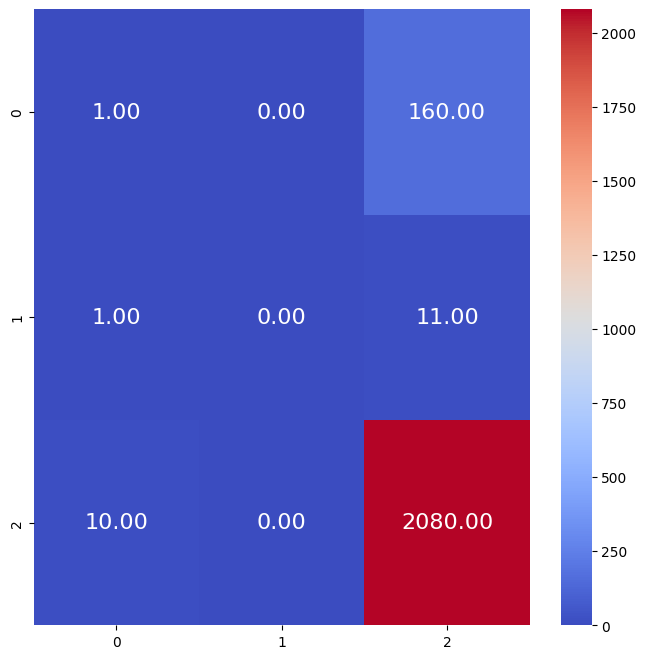

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

### Twitter Sentiment

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import csv
from numpy.random import default_rng

nltk.download('stopwords')
nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
#Read in the reviews
reviewsDF_train = pd.read_csv('../content/drive/MyDrive/Data/trainingTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
reviewsDF_test = pd.read_csv('../content/drive/MyDrive/Data/testTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
reviewsDF = reviewsDF_train.append(reviewsDF_test)
arr_indices_top_drop = default_rng().choice(reviewsDF.index, size=1000000, replace=False)
reviewsDF = reviewsDF.drop(index=arr_indices_top_drop)            

<ipython-input-3-26acf4ad4931>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reviewsDF = reviewsDF_train.append(reviewsDF_test)


In [ ]:
#Drop NA
def dropNA(df):
  return df.dropna()

#Drop Duplicates
def dropDup(df):
  return df.drop_duplicates()

reviewsDF = dropNA(reviewsDF)
reviewsDF = dropDup(reviewsDF)

In [ ]:
#Drop ID column
def dropID(df):
  df = df.drop(['Unnamed: 0'], axis=1)
  return df

#Convert all reviews to a strings 
def toString(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].astype('str')
  return df

#Remove punctuation from text
def removePunc(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  return df

#Split text into individual tokens
def splitSen(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.split(' '))
  return df

#Remove Whitespace elements from list and set case to lower
def removeSpace(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke.lower() for toke in x if toke.isalpha()])
  return df

#Remove stopwords from text
def removeStop(df, reviewColumn):
  stoplist = set(stopwords.words('english'))
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke for toke in x if toke not in stoplist])
  return df

#Get word stems
def getStems(df, reviewColumn):
  porter = PorterStemmer()
  df[reviewColumn] = df[reviewColumn].map(lambda x: [porter.stem(toke) for toke in x ])
  return df

#Create a vocabulary 
def getVocab(df, reviewColumn):
  reviewsVocab = {}
  for x in df[reviewColumn]:
    for token in x:
      if token in reviewsVocab:
        reviewsVocab[token] += 1
      else:
        reviewsVocab[token] = 1
  return reviewsVocab

#Drop infrequent words from vocabulary
def dropInfre(vocab, min, keepCount):
  if keepCount:
    tokens = [(k,v) for k,v in vocab.items() if v >= min]
  else:
    tokens = [k for k,v in vocab.items() if v >= min]
  return tokens

#Combine tokens back into sentence strings
def joinTokens(df, reviewColumn):
  features = [' '.join([word for word in review]) for review in df[reviewColumn]]
  return features

#Clean the whole df
def cleanDF(df, reviewColumn, sentimentColumn): 
  clean = toString(df, reviewColumn)
  clean = removePunc(clean, reviewColumn)
  clean = splitSen(clean, reviewColumn)
  clean = removeSpace(clean, reviewColumn)
  clean = removeStop(clean, reviewColumn)
  #clean = getStems(clean, reviewColumn,)
  clean = clean[[reviewColumn, sentimentColumn]]
  return clean

In [ ]:
cleanReviews = cleanDF(reviewsDF, 'Text', 'Sentiment')

In [ ]:
#Get the vocab
reviewVocab = getVocab(cleanReviews, 'Text')

In [ ]:
#Drop infrequent vocab
trainTokens = dropInfre(vocab=reviewVocab, min=2, keepCount=False)

#### Word Embeddings

In [ ]:
#Combine tokens back into sentence strings
features = joinTokens(cleanReviews, 'Text')

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

68691 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

19.244302996004954% of 356942 words were covered


#### Machine Learning

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(reviewsDF['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 4 else (1 if label == 2 else 0) for label in labels], np.int)

<ipython-input-23-a1318a41ffb4>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 4 else (1 if label == 2 else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    #Get split size 
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    #Get split size 
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
with tf.device('/device:GPU:0'):
  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the Bidirectional RNN w/ LSTM layer to the model
    #LSTM will have an output in the 256 dim space 
    #Outputs of forward and backward RNN will be summed
  model.add(Bidirectional(LSTM(256), merge_mode='sum'))

  #Add a layer with a dropout rate of 0.5
  model.add(Dropout(0.50))

  #A a dense layer with dims 3 and softmax activation function
  model.add(Dense(3, activation='softmax'))

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we stat with 5 epochs and a batch size of 256 to match the dims of LSTM, verbose just outputs training info to user
  model.fit(train_dataset[0], train_dataset[1], epochs=5, batch_size=256, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Epoch 1/5
1876/1876 [==============================] - 383s 202ms/step - loss: 0.5058 - accuracy: 0.7510 - val_loss: 0.4720 - val_accuracy: 0.7725
Epoch 2/5
1876/1876 [==============================] - 381s 203ms/step - loss: 0.4636 - accuracy: 0.7795 - val_loss: 0.4580 - val_accuracy: 0.7812
Epoch 3/5
1876/1876 [==============================] - 387s 206ms/step - loss: 0.4438 - accuracy: 0.7913 - val_loss: 0.4512 - val_accuracy: 0.7861
Epoch 4/5
1876/1876 [==============================] - 387s 206ms/step - loss: 0.4429 - accuracy: 0.7917 - val_loss: 0.4669 - val_accuracy: 0.7802
Epoch 5/5
 738/1876 [==========>...................] - ETA: 3:42 - loss: 0.4274 - accuracy: 0.8015

In [ ]:
# saving model.
#model.save("TwitterRNN")

# load model.
reconstructed_model = keras.models.load_model("../content/drive/MyDrive/Colab Notebooks/ML Models/TwitterRNN")

In [ ]:
with open('test_dataset_main_RNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = reconstructed_model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 77s 1s/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.06      0.75      0.11       142
 (1) Neutral class       0.00      0.00      0.00        14
(2) Positive class       0.91      0.19      0.32      2107

          accuracy                           0.23      2263
         macro avg       0.32      0.32      0.14      2263
      weighted avg       0.85      0.23      0.30      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[ 107    0   35]
 [  10    0    4]
 [1701    0  406]]


<Axes: >

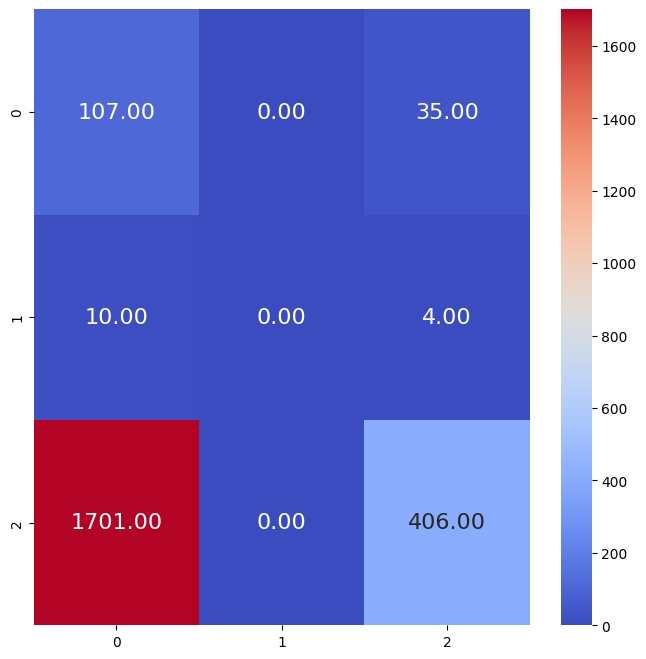

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

## **CNN** 

### Women's Clothing Reviews

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation

nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Read in the data we are working with from file 
df = pd.read_csv("../content/WomensClothingECommerceReviews.csv")

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)

#### DATA PREPROCESSING

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

#### WORD EMBEDDINGS

In [ ]:
#Create a series of product reviews and convert the text to a string then lowercase
reviews = df['Review Text'].astype(str).str.lower()

#Creates the features by converting np series to list
features = reviews.tolist()

In [ ]:
#Loop through the features by their index
for index in range(len(features)):

    #Get the charaters/words at each index of the features, check if it is a punctuation mark, if it isn't add it to the list, join that final list
    all_text = ''.join([character for character in features[index] if character not in punctuation])

    #Look at each review and split it base on the characters '\n', '\r'
    features[index] = re.split(r'\n|\r', all_text)

    #Look at each review, loop through the words in that review and add to list, join that list based on spaces
    features[index] = ' '.join([word for word in features[index]])

#Check the features to make sure we get what we want
features 

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

12272 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

63.35570469798658% of 19370 words were covered


#### MACHINE LEARNING

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)

<ipython-input-46-f761efe04561>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset_main = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
# open file in write mode
with open('test_dataset_main_CNN.npy', 'wb') as f:
    np.save(f, test_dataset_main[0])
    np.save(f, test_dataset_main[1])

In [ ]:
with tf.device('/device:GPU:0'):

  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the 1 dimensional Convolution to the model
    #Let the kernel size be 5 
    #Set activation to relu...relu = max(0, x)
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

  #Add a layer with a Max pooling -> [1, 2, 3, 4]
  #                                  [5, 6, 7, 8] -> [6, 8]
  #                                  [9,10,11,12] -> [14, 16]
  #                                  [13,14,15,16]
  model.add(MaxPooling1D(pool_size=2))

  #Add layer to flatten the dims
  model.add(Flatten())

  #A a dense layer 
  model.add(Dense(3, activation='sigmoid'))

  #Get how the model did
  print(model.summary())

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we start with 5 epochs
  model.fit(train_dataset[0], train_dataset[1], epochs=5, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset_main[0], test_dataset_main[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          5811000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 148, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18944)             0         
                                                                 
 dense (Dense)               (None, 3)                 56835     
                                                                 
Total params: 6,059,963
Trainable params: 248,963
Non-trainable params: 5,811,000
________________________________________

In [ ]:
# saving model.
model.save("../content/drive/MyDrive/Colab Notebooks/ML Models/WomenCNN")

# load model.
#reconstructed_model = keras.models.load_model("my_model")

In [ ]:
with open('test_dataset_main_CNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 0s 3ms/step


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.49      0.13      0.20       149
 (1) Neutral class       0.50      0.08      0.13        13
(2) Positive class       0.94      0.99      0.96      2101

          accuracy                           0.93      2263
         macro avg       0.64      0.40      0.43      2263
      weighted avg       0.90      0.93      0.91      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[  19    0  130]
 [   1    1   11]
 [  19    1 2081]]


<Axes: >

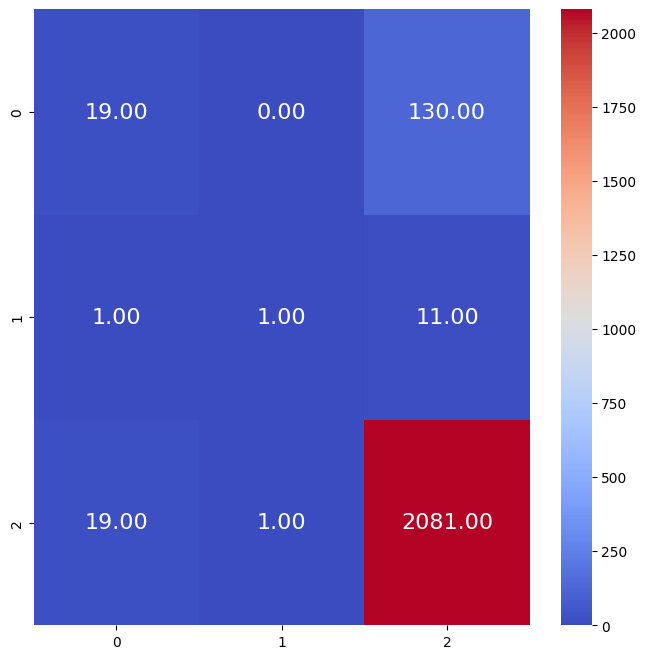

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

### Fipkart Product Reviews

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation

nltk.download('stopwords')
nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Read in the reviews
reviewsDF = pd.read_csv('/content/Dataset-SA.csv')

In [ ]:
#Drop NA
def dropNA(df):
  return df.dropna()

#Drop Duplicates
def dropDup(df):
  return df.drop_duplicates()

reviewsDF = dropNA(reviewsDF)
reviewsDF = dropDup(reviewsDF)

In [ ]:
#Drop ID column
def dropID(df):
  df = df.drop(['Unnamed: 0'], axis=1)
  return df

#Convert all reviews to a strings 
def toString(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].astype('str')
  return df

#Remove punctuation from text
def removePunc(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  return df

#Split text into individual tokens
def splitSen(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.split(' '))
  return df

#Remove Whitespace elements from list and set case to lower
def removeSpace(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke.lower() for toke in x if toke.isalpha()])
  return df

#Remove stopwords from text
def removeStop(df, reviewColumn):
  stoplist = set(stopwords.words('english'))
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke for toke in x if toke not in stoplist])
  return df

#Get word stems
def getStems(df, reviewColumn):
  porter = PorterStemmer()
  df[reviewColumn] = df[reviewColumn].map(lambda x: [porter.stem(toke) for toke in x ])
  return df

#Create a vocabulary 
def getVocab(df, reviewColumn):
  reviewsVocab = {}
  for x in df[reviewColumn]:
    for token in x:
      if token in reviewsVocab:
        reviewsVocab[token] += 1
      else:
        reviewsVocab[token] = 1
  return reviewsVocab

#Drop infrequent words from vocabulary
def dropInfre(vocab, min, keepCount):
  if keepCount:
    tokens = [(k,v) for k,v in vocab.items() if v >= min]
  else:
    tokens = [k for k,v in vocab.items() if v >= min]
  return tokens

#Combine tokens back into sentence strings
def joinTokens(df, reviewColumn):
  features = [' '.join([word for word in review]) for review in df[reviewColumn]]
  return features

#Clean the whole df
def cleanDF(df, reviewColumn, sentimentColumn): 
  clean = toString(df, reviewColumn)
  clean = removePunc(clean, reviewColumn)
  clean = splitSen(clean, reviewColumn)
  clean = removeSpace(clean, reviewColumn)
  clean = removeStop(clean, reviewColumn)
  #clean = getStems(clean, reviewColumn,)
  clean = clean[[reviewColumn, sentimentColumn]]
  return clean

In [ ]:
cleanReviews = cleanDF(reviewsDF, 'Summary', 'Sentiment')

In [ ]:
#Get the vocab
reviewVocab = getVocab(cleanReviews, 'Summary')

In [ ]:
#Drop infrequent vocab
trainTokens = dropInfre(vocab=reviewVocab, min=2, keepCount=False)

#### Word Embeddings

In [ ]:
#Combine tokens back into sentence strings
features = joinTokens(cleanReviews, 'Summary')

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 40404


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

14866 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

36.793386793386794% of 40404 words were covered


#### Machine Learning

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(reviewsDF['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'positive' else (1 if label == 'neutral' else 0) for label in labels], np.int)

<ipython-input-74-d68c9848718e>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 'positive' else (1 if label == 'neutral' else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    #Get split size 
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    #Get split size 
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
with tf.device('/device:GPU:0'):
  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the 1 dimensional Convolution to the model
    #Let the kernel size be 5 
    #Set activation to relu...relu = max(0, x)
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

  #Add a layer with a Max pooling -> [1, 2, 3, 4]
  #                                  [5, 6, 7, 8] -> [6, 8]
  #                                  [9,10,11,12] -> [14, 16]
  #                                  [13,14,15,16]
  model.add(MaxPooling1D(pool_size=2))

  #Add layer to flatten the dims
  model.add(Flatten())

  #A a dense layer 
  model.add(Dense(3, activation='sigmoid'))

  #Get how the model did
  print(model.summary())

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we start with 5 epochs
  model.fit(train_dataset[0], train_dataset[1], epochs=5, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          12121200  
                                                                 
 conv1d_1 (Conv1D)           (None, 296, 128)          192128    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 148, 128)         0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 18944)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 56835     
                                                                 
Total params: 12,370,163
Trainable params: 248,963
Non-trainable params: 12,121,200
____________________________________

In [ ]:
# saving model.
model.save("/content/drive/MyDrive/Colab Notebooks/ML Models/FlipkartCNN")

# load model.
#reconstructed_model = keras.models.load_model("my_model")

In [ ]:
with open('/content/test_dataset_main_CNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 0s 2ms/step


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.02      0.01      0.01       149
 (1) Neutral class       0.00      0.00      0.00        13
(2) Positive class       0.93      0.97      0.95      2101

          accuracy                           0.90      2263
         macro avg       0.31      0.33      0.32      2263
      weighted avg       0.86      0.90      0.88      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[   1    0  148]
 [   2    0   11]
 [  56    2 2043]]


<Axes: >

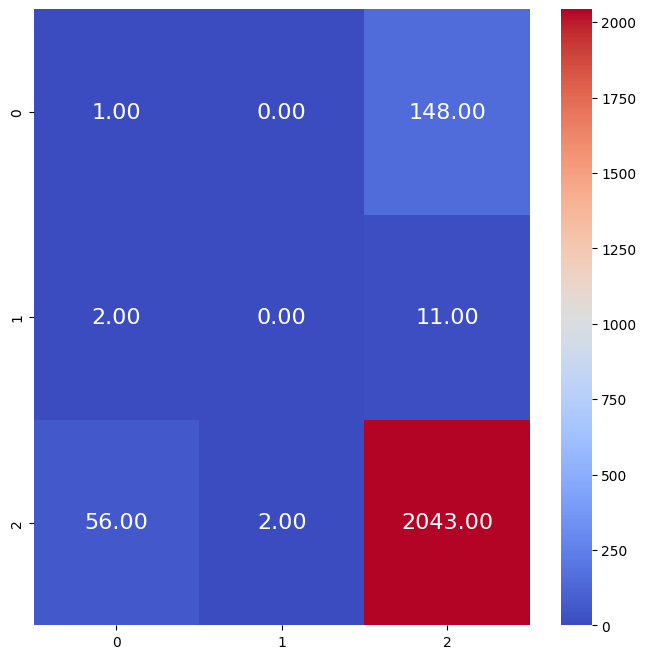

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

### Twitter Sentiment

#### IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation
import string
import csv
from nltk.corpus import stopwords
from numpy.random import default_rng

nltk.download('stopwords')
nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Train with GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Read in the reviews
reviewsDF_train = pd.read_csv('../content/drive/MyDrive/Data/trainingTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
reviewsDF_test = pd.read_csv('../content/drive/MyDrive/Data/testTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
reviewsDF = reviewsDF_train.append(reviewsDF_test)
arr_indices_top_drop = default_rng().choice(reviewsDF.index, size=1000000, replace=False)
reviewsDF = reviewsDF.drop(index=arr_indices_top_drop)            

<ipython-input-88-26acf4ad4931>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reviewsDF = reviewsDF_train.append(reviewsDF_test)


In [ ]:
#Drop NA
def dropNA(df):
  return df.dropna()

#Drop Duplicates
def dropDup(df):
  return df.drop_duplicates()

reviewsDF = dropNA(reviewsDF)
reviewsDF = dropDup(reviewsDF)

In [ ]:
#Drop ID column
def dropID(df):
  df = df.drop(['Unnamed: 0'], axis=1)
  return df

#Convert all reviews to a strings 
def toString(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].astype('str')
  return df

#Remove punctuation from text
def removePunc(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  return df

#Split text into individual tokens
def splitSen(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: x.split(' '))
  return df

#Remove Whitespace elements from list and set case to lower
def removeSpace(df, reviewColumn):
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke.lower() for toke in x if toke.isalpha()])
  return df

#Remove stopwords from text
def removeStop(df, reviewColumn):
  stoplist = set(stopwords.words('english'))
  df[reviewColumn] = df[reviewColumn].map(lambda x: [toke for toke in x if toke not in stoplist])
  return df

#Get word stems
def getStems(df, reviewColumn):
  porter = PorterStemmer()
  df[reviewColumn] = df[reviewColumn].map(lambda x: [porter.stem(toke) for toke in x ])
  return df

#Create a vocabulary 
def getVocab(df, reviewColumn):
  reviewsVocab = {}
  for x in df[reviewColumn]:
    for token in x:
      if token in reviewsVocab:
        reviewsVocab[token] += 1
      else:
        reviewsVocab[token] = 1
  return reviewsVocab

#Drop infrequent words from vocabulary
def dropInfre(vocab, min, keepCount):
  if keepCount:
    tokens = [(k,v) for k,v in vocab.items() if v >= min]
  else:
    tokens = [k for k,v in vocab.items() if v >= min]
  return tokens

#Combine tokens back into sentence strings
def joinTokens(df, reviewColumn):
  features = [' '.join([word for word in review]) for review in df[reviewColumn]]
  return features

#Clean the whole df
def cleanDF(df, reviewColumn, sentimentColumn): 
  clean = toString(df, reviewColumn)
  clean = removePunc(clean, reviewColumn)
  clean = splitSen(clean, reviewColumn)
  clean = removeSpace(clean, reviewColumn)
  clean = removeStop(clean, reviewColumn)
  #clean = getStems(clean, reviewColumn,)
  clean = clean[[reviewColumn, sentimentColumn]]
  return clean

In [ ]:
cleanReviews = cleanDF(reviewsDF, 'Text', 'Sentiment')

In [ ]:
#Get the vocab
reviewVocab = getVocab(cleanReviews, 'Text')

In [ ]:
#Drop infrequent vocab
trainTokens = dropInfre(vocab=reviewVocab, min=2, keepCount=False)

#### Word Embeddings

In [ ]:
#Combine tokens back into sentence strings
features = joinTokens(cleanReviews, 'Text')

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 356691


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/Data/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

68715 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

19.264573538440835% of 356691 words were covered


#### Machine Learning

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(reviewsDF['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 4 else (1 if label == 2 else 0) for label in labels], np.int)

<ipython-input-101-a1318a41ffb4>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 4 else (1 if label == 2 else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    #Get split size 
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    #Get split size 
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.80, validation_size=0.50)

In [ ]:
with tf.device('/device:GPU:0'):
  #Create an instance of a Sequential model
  model = Sequential()

  #Create a variable that stores the word embeddings that we created earlier
  e = Embedding(vocabulary_size, max_length,
                weights=[embedding_matrix], input_length=max_length, trainable=False)

  #Add the embeddings layer to the model
  model.add(e)

  #Add the 1 dimensional Convolution to the model
    #Let the kernel size be 5 
    #Set activation to relu...relu = max(0, x)
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

  #Add a layer with a Max pooling -> [1, 2, 3, 4]
  #                                  [5, 6, 7, 8] -> [6, 8]
  #                                  [9,10,11,12] -> [14, 16]
  #                                  [13,14,15,16]
  model.add(MaxPooling1D(pool_size=2))

  #Add layer to flatten the dims
  model.add(Flatten())

  #A a dense layer 
  model.add(Dense(3, activation='sigmoid'))

  #Get how the model did
  print(model.summary())

  #Compile the model and evaluate based with the provided arguements 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Fit the model to the training data, we start with 5 epochs
  model.fit(train_dataset[0], train_dataset[1], epochs=5, verbose=1,
            validation_data=(validation_dataset[0], validation_dataset[1]))

  #Evaluate the model based on the test data
  score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

  #Print the loss and accuracy to the screen
  print('loss : {}, acc : {}'.format(score[0], score[1]))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          107007300 
                                                                 
 conv1d_2 (Conv1D)           (None, 296, 128)          192128    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 148, 128)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 18944)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 56835     
                                                                 
Total params: 107,256,263
Trainable params: 248,963
Non-trainable params: 107,007,300
__________________________________

In [ ]:
# saving model.
model.save("../content/drive/MyDrive/Colab Notebooks/ML Models/TwitterCNN")

# load model.
#reconstructed_model = keras.models.load_model("my_model")

In [ ]:
with open('test_dataset_main_CNN.npy', 'rb') as f:
    i0 = np.load(f)
    i1 = np.load(f)
    f.close()
test_dataset_main = [i0, i1]

In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset_main[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset_main[1], axis=1), test_predictions, target_names=class_names)

71/71 [==============================] - 0s 3ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.07      0.70      0.12       149
 (1) Neutral class       0.00      0.00      0.00        13
(2) Positive class       0.93      0.32      0.48      2101

          accuracy                           0.35      2263
         macro avg       0.33      0.34      0.20      2263
      weighted avg       0.87      0.35      0.45      2263



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset_main[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[ 105    0   44]
 [   8    0    5]
 [1422    0  679]]


<Axes: >

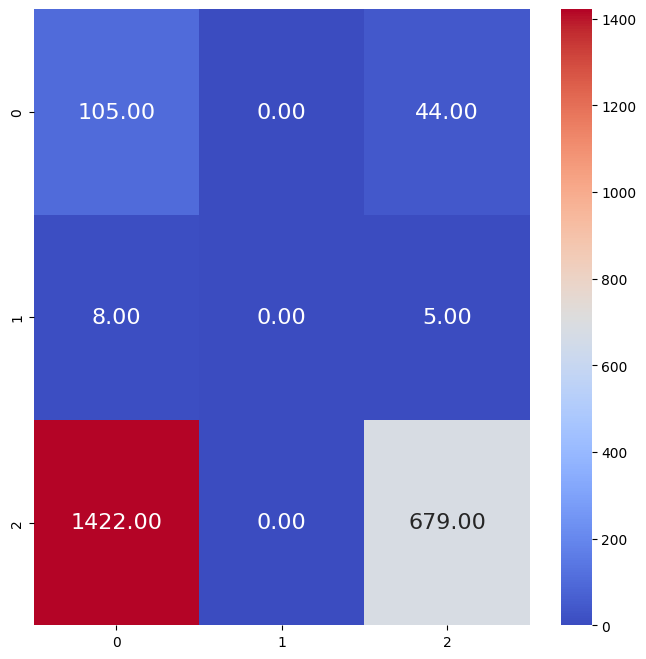

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')

## **BERT**

### Women's Clothing

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

nltk.download('vader_lexicon')

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Read in the data we are working with from file 
df = pd.read_csv("../content/WomensClothingECommerceReviews.csv")

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class_names = ['Positive', 'Neutral', 'Negative']

In [ ]:
df.columns
df = df.rename(columns={"Review Text": "ReviewText"})
df.columns

Index(['Clothing ID', 'Age', 'Title', 'ReviewText', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Polarity Score', 'Neutral Score',
       'Negative Score', 'Positive Score', 'Sentiment'],
      dtype='object')

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], int)

In [ ]:
df['Sentiment'] = labels

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.ReviewText:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

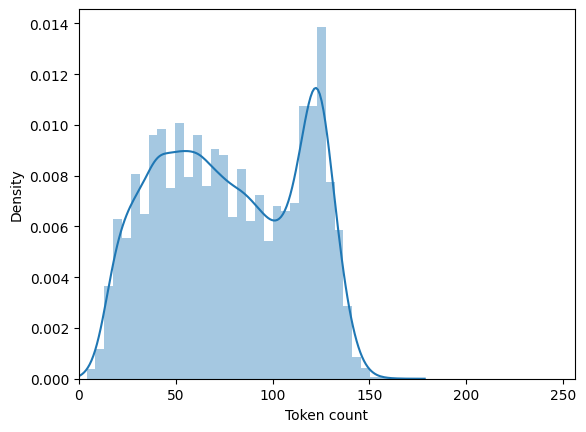

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(18102, 15) (2263, 15) (2263, 15)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.ReviewText.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of iterations 
EPOCHS = 2

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Function for model evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#with tf.device('/device:GPU:0'):
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.21165048930499467 accuracy 0.9369130482819578
Val   loss 0.20818938045027915 accuracy 0.9443216968625718

Epoch 2/2
----------
Train loss 0.14452317716912103 accuracy 0.9581261739034361
Val   loss 0.17800363604779498 accuracy 0.9513919575784358

CPU times: user 16min 15s, sys: 6.07 s, total: 16min 22s
Wall time: 16min 30s


In [ ]:
history['train_acc']

[tensor(0.9369, device='cuda:0', dtype=torch.float64),
 tensor(0.9581, device='cuda:0', dtype=torch.float64)]

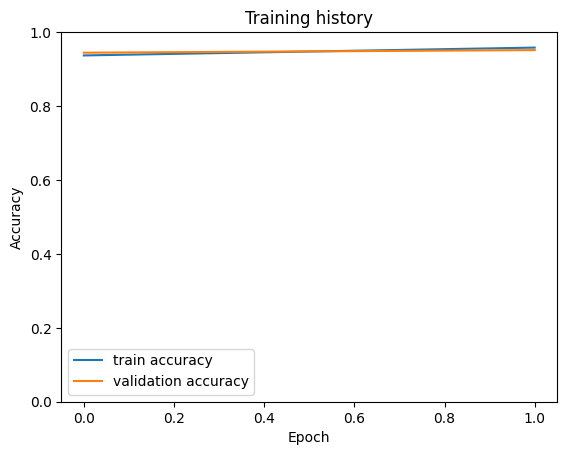

In [ ]:
# Plot training and validation accuracy
plt.plot([x.cpu() for x in history['train_acc']], label='train accuracy')
plt.plot([x.cpu() for x in history['val_acc']], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9496243923994697

In [ ]:
# Helper function to get predictions from models
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Positive       0.59      0.47      0.53       127
     Neutral       0.50      0.80      0.62        10
    Negative       0.97      0.98      0.97      2126

    accuracy                           0.95      2263
   macro avg       0.69      0.75      0.71      2263
weighted avg       0.95      0.95      0.95      2263



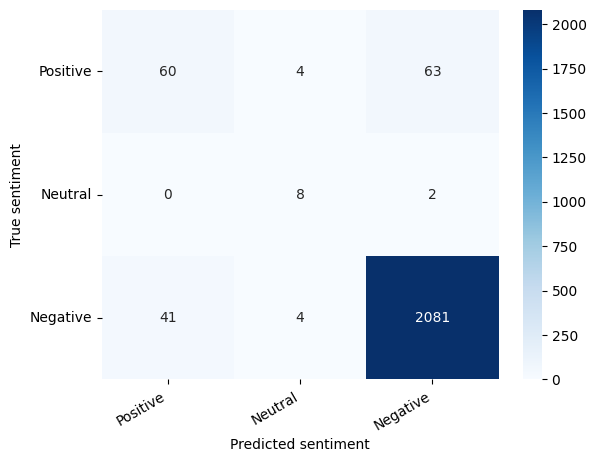

In [ ]:
# Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Flipkart Reviews

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 17.7 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

nltk.download('vader_lexicon')

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#Read in the data we are working with from file 
df = pd.read_csv("../content/WomensClothingECommerceReviews.csv")

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)
df = df.dropna()

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class_names = ['positive', 'neutral', 'negative']

In [ ]:
df.columns
df = df.rename(columns={"Review Text": "ReviewText"})
df.columns

Index(['Clothing ID', 'Age', 'Title', 'ReviewText', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Polarity Score', 'Neutral Score',
       'Negative Score', 'Positive Score', 'Sentiment'],
      dtype='object')

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], int)

In [ ]:
df['Sentiment'] = labels

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.ReviewText:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

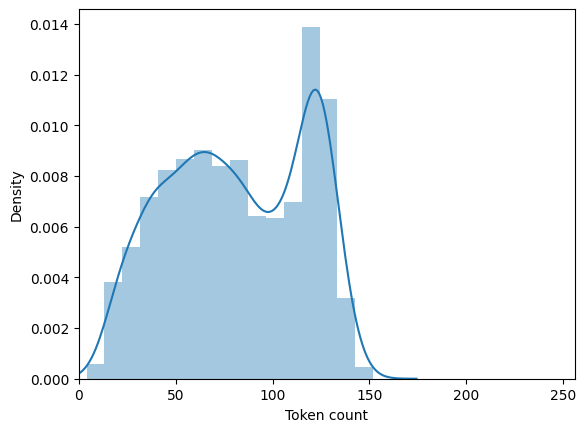

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_Train, df_test_main = train_test_split(df, test_size=0.99, random_state=RANDOM_SEED)

print(df_Train.shape, df_test_main.shape)

(23, 15) (2373, 15)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.ReviewText.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
#train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_main = create_data_loader(df_test_main, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(test_data_loader_main))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
#Read in the reviews
df = pd.read_csv('/content/Dataset-SA.csv')

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class_names = ['positive', 'neutral', 'negative']

In [ ]:
df.columns
df = df.rename(columns={"Summary": "ReviewText"})
df = df.dropna()
df.columns

Index(['product_name', 'product_price', 'Rate', 'Review', 'ReviewText',
       'Sentiment'],
      dtype='object')

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'positive' else (1 if label == 'neutral' else 0) for label in labels], np.int)

In [ ]:
df['Sentiment'] = labels

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.ReviewText:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

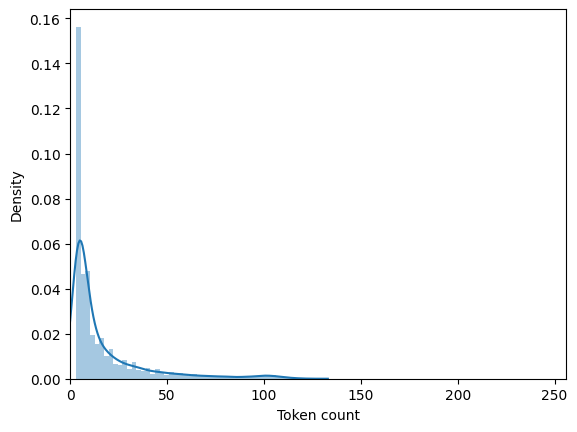

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_test.shape)

(8903, 6) (1113, 6)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.ReviewText.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(test_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of iterations 
EPOCHS = 2

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Function for model evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#with tf.device('/device:GPU:0'):
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.2773178057386448 accuracy 0.9083455015163429
Val   loss 0.23040935479470395 accuracy 0.9299191374663073

Epoch 2/2
----------
Train loss 0.15741023664777393 accuracy 0.9487813096708975
Val   loss 0.21785779419587925 accuracy 0.9362084456424079

CPU times: user 8h 31min 33s, sys: 1min 41s, total: 8h 33min 14s
Wall time: 8h 35min 19s


In [ ]:
history['train_acc']

[tensor(0.9083, dtype=torch.float64), tensor(0.9488, dtype=torch.float64)]

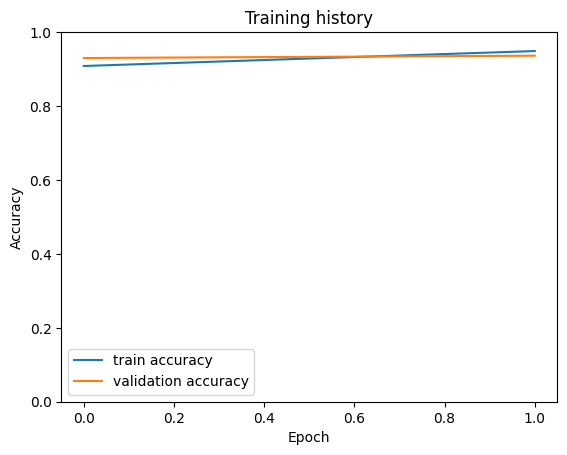

In [ ]:
# Plot training and validation accuracy
plt.plot([x.cpu() for x in history['train_acc']], label='train accuracy')
plt.plot([x.cpu() for x in history['val_acc']], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9415992812219227

In [ ]:
# Helper function to get predictions from models
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.84      0.90      0.87       141
     neutral       0.43      0.22      0.29        41
    negative       0.97      0.98      0.97       931

    accuracy                           0.94      1113
   macro avg       0.75      0.70      0.71      1113
weighted avg       0.93      0.94      0.94      1113



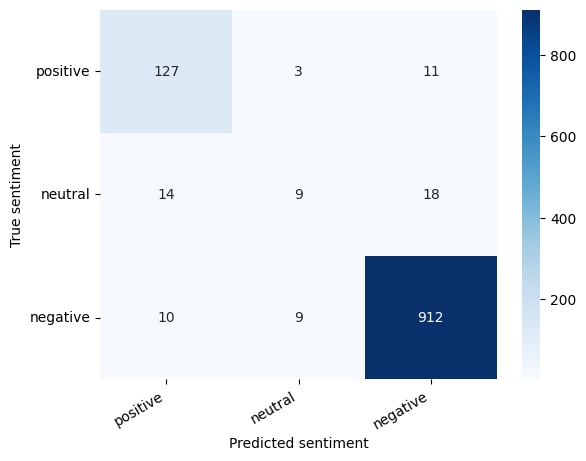

In [ ]:
# Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader_main,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

1.9982030548068284

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test_Main = get_predictions(
    model,
    test_data_loader_main
)

In [ ]:
print(classification_report(y_test_Main, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.60      0.37      0.46       154
     neutral       0.15      0.22      0.18         9
    negative       0.96      0.98      0.97      2210

    accuracy                           0.94      2373
   macro avg       0.57      0.52      0.54      2373
weighted avg       0.93      0.94      0.93      2373



In [ ]:
# Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Twitter

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.0 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation
import string
import csv
from nltk.corpus import stopwords
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

nltk.download('vader_lexicon')

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
#Read in the data we are working with from file 
#df = pd.read_csv("../content/WomensClothingECommerceReviews.csv")
df = pd.read_csv('../content/drive/MyDrive/Data/WomensClothingECommerceReviews.csv')

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class_names = ['positive', 'neutral', 'negative']

In [ ]:
df.columns
df = df.rename(columns={"Review Text": "ReviewText"})
df.columns

Index(['Clothing ID', 'Age', 'Title', 'ReviewText', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Polarity Score', 'Neutral Score',
       'Negative Score', 'Positive Score', 'Sentiment'],
      dtype='object')

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], int)

In [ ]:
df['Sentiment'] = labels

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.ReviewText:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

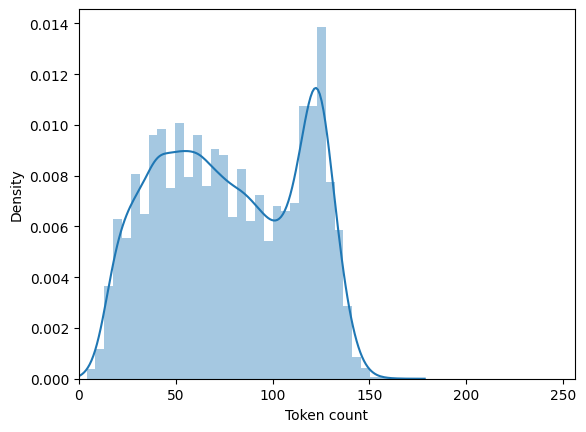

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_Train, df_test_main = train_test_split(df, test_size=0.99, random_state=RANDOM_SEED)

print(df_Train.shape, df_test_main.shape)

(226, 15) (22402, 15)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.ReviewText.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
#train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_main = create_data_loader(df_test_main, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(test_data_loader_main))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
#Read in the reviews
df_train = pd.read_csv('../content/drive/MyDrive/Data/trainingTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
df_test = pd.read_csv('../content/drive/MyDrive/Data/testTwitter.csv', names=["Sentiment", "Date", "ID", "Search", "User", "Text"], encoding='latin-1')
df = df_train.append(df_test)
arr_indices_top_drop = default_rng().choice(df.index, size=1500000, replace=False)
df = df.drop(index=arr_indices_top_drop)      

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class_names = ['positive', 'neutral', 'negative']

In [ ]:
df.columns
df = df.rename(columns={"Text": "ReviewText"})
df.columns

Index(['Sentiment', 'Date', 'ID', 'Search', 'User', 'ReviewText'], dtype='object')

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 4 else (1 if label == 2 else 0) for label in labels], np.int)

In [ ]:
df['Sentiment'] = labels

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.ReviewText:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

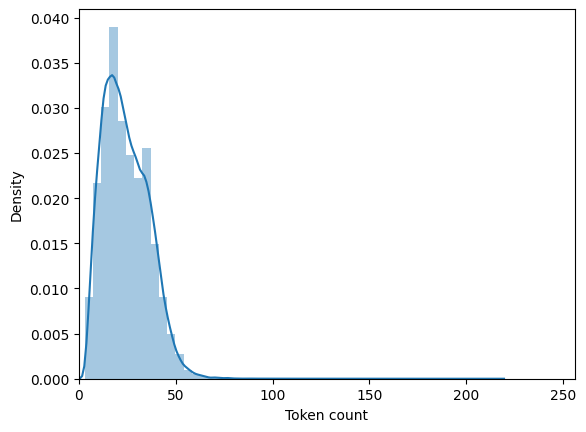

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(df_train.shape, df_test.shape)

(80356, 6) (10045, 6)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.ReviewText.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(test_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of iterations 
EPOCHS = 2

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Function for model evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#with tf.device('/device:GPU:0'):
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.414722151472859 accuracy 0.8146373637313954
Val   loss 0.36213947379380274 accuracy 0.8384109916367981

Epoch 2/2
----------
Train loss 0.2710323391508933 accuracy 0.8942580516700682
Val   loss 0.41536013041711917 accuracy 0.841995221027479

CPU times: user 1h 10min 21s, sys: 31.5 s, total: 1h 10min 53s
Wall time: 1h 11min 21s


In [ ]:
history['train_acc']

[tensor(0.8146, device='cuda:0', dtype=torch.float64),
 tensor(0.8943, device='cuda:0', dtype=torch.float64)]

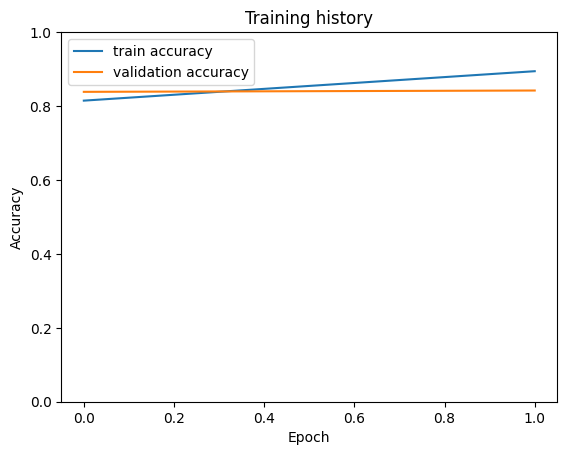

In [ ]:
# Plot training and validation accuracy
plt.plot([x.cpu() for x in history['train_acc']], label='train accuracy')
plt.plot([x.cpu() for x in history['val_acc']], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8439024390243902

In [ ]:
# Helper function to get predictions from models
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
# Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader_main,
  loss_fn,
  device,
  len(df_test_main)
)

test_acc.item()

0.7657798410856174

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test_Main = get_predictions(
    model,
    test_data_loader_main
)

In [ ]:
print(classification_report(y_test_Main, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.19      0.80      0.30      1424
     neutral       0.00      0.00      0.00       139
    negative       0.98      0.77      0.86     20839

    accuracy                           0.77     22402
   macro avg       0.39      0.52      0.39     22402
weighted avg       0.92      0.77      0.82     22402



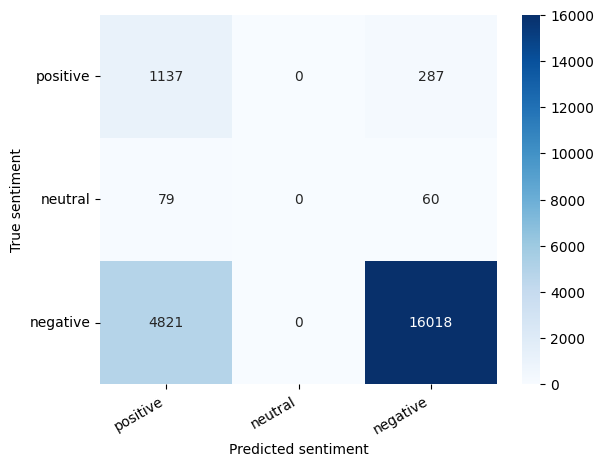

In [ ]:
# Confusion Matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test_Main, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)